# House Rent Prediction - Linear Regression Analysis

**Dataset**: [House Rent Prediction Dataset](https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset) from Kaggle

**Objective**: Build a linear regression model to predict house rent in Indian cities. Compare OLS, Ridge, Lasso, and ElasticNet regularization methods.

**Important**: This notebook follows proper ML practices:
- Train/test split is done FIRST (before any feature engineering)
- All transformations (clipping, scaling) are fitted on train data only
- Test data is transformed using train statistics
- Final evaluation uses ORIGINAL (non-clipped) rent values

In [38]:
# Download dataset from Kaggle
try:
    import kagglehub
except ImportError:
    %pip install -q kagglehub
    import kagglehub

path = kagglehub.dataset_download("iamsouravbanerjee/house-rent-prediction-dataset")
print("Dataset path:", path)

Dataset path: C:\Users\francji1\.cache\kagglehub\datasets\iamsouravbanerjee\house-rent-prediction-dataset\versions\9


In [39]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
dataset_dir = Path(path)
csv_path = list(dataset_dir.rglob("House_Rent_Dataset.csv"))[0]
house = pd.read_csv(csv_path)
print(f"Dataset shape: {house.shape}")
house.head()

Dataset shape: (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [40]:
house.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


## 1. Initial Data Inspection

Quick look at data types, missing values, and target distribution before splitting.

Missing values: 0

Rent statistics:
  Min: 1,200
  Max: 3,500,000
  Mean: 34,993
  Median: 16,000
  Skewness: 21.41


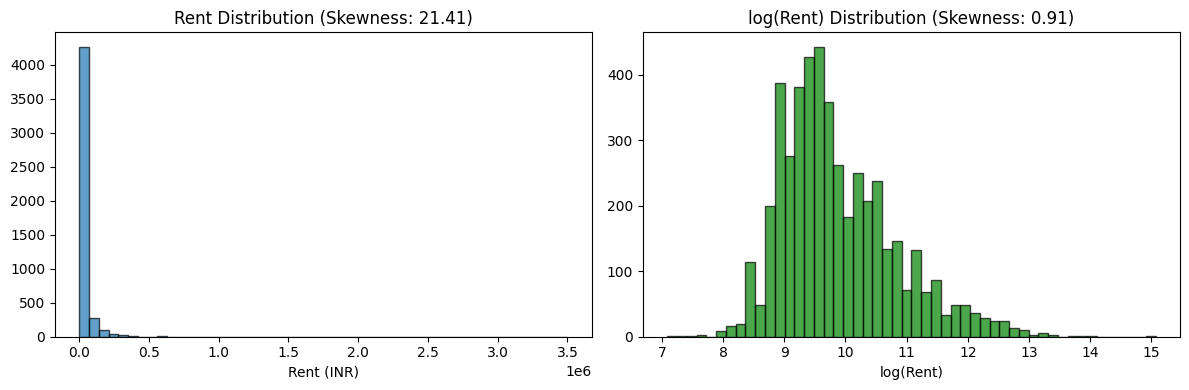

In [41]:
# Basic info
print("Missing values:", house.isnull().sum().sum())
print(f"\nRent statistics:")
print(f"  Min: {house['Rent'].min():,}")
print(f"  Max: {house['Rent'].max():,}")
print(f"  Mean: {house['Rent'].mean():,.0f}")
print(f"  Median: {house['Rent'].median():,.0f}")
print(f"  Skewness: {house['Rent'].skew():.2f}")

# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(house['Rent'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title(f'Rent Distribution (Skewness: {house["Rent"].skew():.2f})')
axes[0].set_xlabel('Rent (INR)')

axes[1].hist(np.log1p(house['Rent']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title(f'log(Rent) Distribution (Skewness: {np.log1p(house["Rent"]).skew():.2f})')
axes[1].set_xlabel('log(Rent)')
plt.tight_layout()
plt.show()

## 2. Train/Test Split (BEFORE Feature Engineering!)

**Critical**: We split the data FIRST, then do all feature engineering only on training data.
This prevents data leakage from test set into our preprocessing decisions.

In [42]:
from sklearn.model_selection import train_test_split

# Split indices FIRST - before any feature engineering
# Using test_size=0.25 and random_state=42 
train_idx, test_idx = train_test_split(
    house.index,
    test_size=0.25,
    random_state=42
)

# Create train and test DataFrames
train_df = house.loc[train_idx].copy()
test_df = house.loc[test_idx].copy()

# Store ORIGINAL rent values for final evaluation (never clip these!)
y_train_original = train_df['Rent'].copy()
y_test_original = test_df['Rent'].copy()

print(f"Train set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nOriginal Rent preserved for final evaluation:")
print(f"  Train Rent range: {y_train_original.min():,} - {y_train_original.max():,}")
print(f"  Test Rent range: {y_test_original.min():,} - {y_test_original.max():,}")

Train set: 3559 samples
Test set: 1187 samples

Original Rent preserved for final evaluation:
  Train Rent range: 1,200 - 3,500,000
  Test Rent range: 1,800 - 1,200,000


## 3. Feature Engineering (on Train Data Only!)

All statistics for clipping, encoding, etc. are computed from TRAIN data only,
then applied to both train and test sets.

In [43]:
def parse_floor(floor_str):
    """Extract floor number and total floors from string like '2 out of 5'."""
    if 'out of' in floor_str:
        parts = floor_str.split(' out of ')
        current = parts[0].strip()
        total = int(parts[1].strip())
        floor_map = {'Ground': 0, 'Lower Basement': -1, 'Upper Basement': -2}
        current = floor_map.get(current, int(current) if current.isdigit() else 0)
        return current, total
    return 0, 1

def engineer_features(df, rent_cap=None, size_cap=None, size_min=50, fit=False):
    """
    Apply feature engineering to a DataFrame.

    Parameters:
    - df: input DataFrame
    - rent_cap, size_cap: clipping thresholds (computed from train if fit=True)
    - fit: if True, compute thresholds from this data (use for train only)

    Returns:
    - df: transformed DataFrame
    - params: dict with fitted parameters (only if fit=True)
    """
    df = df.copy()
    params = {}

    # Parse Floor
    df[['Current_Floor', 'Total_Floors']] = df['Floor'].apply(
        lambda x: pd.Series(parse_floor(x))
    )

    # Parse date
    df['Posted On'] = pd.to_datetime(df['Posted On'])
    df['Posted_Month'] = df['Posted On'].dt.month

    # Compute clipping thresholds from train data
    if fit:
        rent_cap = df['Rent'].quantile(0.999)
        size_cap = df['Size'].quantile(0.999)
        params['rent_cap'] = rent_cap
        params['size_cap'] = size_cap
        params['size_min'] = size_min
        print(f"Fitted thresholds (from train data):")
        print(f"  Rent cap (99.9%): {rent_cap:,.0f}")
        print(f"  Size cap (99.9%): {size_cap:,.0f}")
        print(f"  Size min: {size_min}")

    # Apply clipping (using train thresholds)
    df['Rent_capped'] = df['Rent'].clip(upper=rent_cap)
    df['Size_capped'] = df['Size'].clip(lower=size_min, upper=size_cap)

    # Log transformations
    df['log_Rent'] = np.log1p(df['Rent_capped'])
    df['log_Size'] = np.log1p(df['Size_capped'])

    # Ratio features
    df['Bathroom_per_BHK'] = df['Bathroom'] / (df['BHK'] + 0.1)
    df['Size_per_BHK'] = df['Size_capped'] / (df['BHK'] + 0.1)
    df['log_Size_per_BHK'] = np.log1p(df['Size_per_BHK'])

    # Floor features
    df['Floor_Ratio'] = df['Current_Floor'] / (df['Total_Floors'] + 0.1)
    df['Is_Ground_Floor'] = (df['Current_Floor'] == 0).astype(int)
    df['Is_Top_Floor'] = (df['Current_Floor'] == df['Total_Floors']).astype(int)
    df['Is_High_Rise'] = (df['Total_Floors'] > 10).astype(int)

    # Interaction terms
    df['BHK_log_Size'] = df['BHK'] * df['log_Size']
    df['BHK_Bathroom'] = df['BHK'] * df['Bathroom']

    # Polynomial terms
    df['BHK_squared'] = df['BHK'] ** 2
    df['log_Size_squared'] = df['log_Size'] ** 2

    if fit:
        return df, params
    return df

# Apply to TRAIN data (fit=True to compute thresholds)
train_df, train_params = engineer_features(train_df, fit=True)

# Apply to TEST data using TRAIN thresholds (fit=False)
test_df = engineer_features(
    test_df,
    rent_cap=train_params['rent_cap'],
    size_cap=train_params['size_cap'],
    size_min=train_params['size_min'],
    fit=False
)

print(f"\nFeatures created: {len([c for c in train_df.columns if c not in house.columns])}")

Fitted thresholds (from train data):
  Rent cap (99.9%): 688,840
  Size cap (99.9%): 4,761
  Size min: 50

Features created: 18


In [44]:
# City clustering - compute tiers from TRAIN data only
city_median_rent = train_df.groupby('City')['Rent'].median()
city_tier_map = {
    city: 'Tier1' if rent > 30000 else ('Tier2' if rent > 15000 else 'Tier3')
    for city, rent in city_median_rent.items()
}

# Apply to both train and test
train_df['City_Tier'] = train_df['City'].map(city_tier_map)
test_df['City_Tier'] = test_df['City'].map(city_tier_map)

print("City tier mapping (from train data):")
for city, tier in sorted(city_tier_map.items(), key=lambda x: city_median_rent[x[0]], reverse=True):
    print(f"  {city}: {tier} (median rent: {city_median_rent[city]:,.0f})")

City tier mapping (from train data):
  Mumbai: Tier1 (median rent: 52,000)
  Delhi: Tier2 (median rent: 16,500)
  Bangalore: Tier3 (median rent: 14,000)
  Chennai: Tier3 (median rent: 14,000)
  Hyderabad: Tier3 (median rent: 14,000)
  Kolkata: Tier3 (median rent: 8,500)


In [45]:
# Handle rare categories - decisions based on TRAIN data only
for df in [train_df, test_df]:
    df['Area Type'] = df['Area Type'].replace('Built Area', 'Other')
    df['Point of Contact'] = df['Point of Contact'].replace('Contact Builder', 'Contact Agent')

# Group rare localities (< 5 occurrences in TRAIN)
train_locality_counts = train_df['Area Locality'].value_counts()
rare_localities = train_locality_counts[train_locality_counts < 5].index.tolist()

train_df['Area Locality'] = train_df['Area Locality'].replace(rare_localities, 'Other')
test_df['Area Locality'] = test_df['Area Locality'].apply(
    lambda x: 'Other' if x in rare_localities or x not in train_locality_counts.index else x
)

print(f"Area Locality categories: {train_df['Area Locality'].nunique()} (reduced from {len(train_locality_counts)})")

Area Locality categories: 150 (reduced from 1838)


## 4. Model Preparation

Select features and encode categoricals.

In [46]:
# Define features (same for train and test)
numerical_features = [
    'log_Size', 'BHK', 'Bathroom', 'Current_Floor', 'Total_Floors', 'Posted_Month',
    'BHK_log_Size', 'BHK_Bathroom', 'Bathroom_per_BHK', 'log_Size_per_BHK',
    'Floor_Ratio', 'Is_Ground_Floor', 'Is_Top_Floor', 'Is_High_Rise',
    'BHK_squared', 'log_Size_squared'
]
categorical_features = ['City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact', 'City_Tier']

# Prepare X (features) and y (target)
# Target is log(Rent_capped) for training, but we evaluate on ORIGINAL Rent
X_train = train_df[numerical_features + categorical_features]
X_test = test_df[numerical_features + categorical_features]

y_train = train_df['log_Rent']  # log of capped rent for training
y_test = test_df['log_Rent']    # log of capped rent for metrics comparison

# IMPORTANT: y_test_original and y_train_original (defined earlier) contain
# the ORIGINAL, NON-CLIPPED rent values for final evaluation!

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTarget (log scale):")
print(f"  y_train range: {y_train.min():.2f} - {y_train.max():.2f}")
print(f"  y_test range: {y_test.min():.2f} - {y_test.max():.2f}")

X_train shape: (3559, 21)
X_test shape: (1187, 21)

Target (log scale):
  y_train range: 7.09 - 13.44
  y_test range: 7.50 - 13.44


In [47]:
# One-hot encoding - fit on train, transform both
from sklearn.preprocessing import OneHotEncoder

# Fit encoder on train data only
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
encoder.fit(X_train[categorical_features])

# Transform both sets
X_train_cat = encoder.transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

# Get feature names
cat_feature_names = encoder.get_feature_names_out(categorical_features)

# Combine numerical and encoded categorical
X_train_final = np.hstack([X_train[numerical_features].values, X_train_cat])
X_test_final = np.hstack([X_test[numerical_features].values, X_test_cat])

feature_names = list(numerical_features) + list(cat_feature_names)

print(f"Final feature count: {len(feature_names)}")
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

Final feature count: 28
X_train_final shape: (3559, 28)
X_test_final shape: (1187, 28)


In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check VIF for numerical features only
X_numeric = X_train[numerical_features].astype(float)
vif_data = pd.DataFrame({
    'Feature': X_numeric.columns,
    'VIF': [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]
}).sort_values('VIF', ascending=False)

print("Variance Inflation Factors (VIF > 10 indicates multicollinearity):")
print(vif_data.head(10))

Variance Inflation Factors (VIF > 10 indicates multicollinearity):
             Feature           VIF
0           log_Size  67890.985246
9   log_Size_per_BHK  37046.211208
1                BHK   5117.586982
15  log_Size_squared   2753.897483
6       BHK_log_Size   1637.054509
2           Bathroom   1299.046056
14       BHK_squared    610.956935
7       BHK_Bathroom    483.443760
8   Bathroom_per_BHK    272.134180
5       Posted_Month     51.442994


## 5. Model Training

### 5.1 Statsmodels OLS - Full Model

First, we fit OLS using statsmodels to get detailed summary with p-values, confidence intervals, and diagnostic statistics.

In [49]:
import statsmodels.api as sm

# Create design matrix with proper feature names
X_train_sm = pd.DataFrame(X_train_final, columns=feature_names)
X_train_sm = sm.add_constant(X_train_sm)  # adds intercept column

X_test_sm = pd.DataFrame(X_test_final, columns=feature_names)
X_test_sm = sm.add_constant(X_test_sm)

# Reset index to align with design matrix (statsmodels requires matching indices)
y_train_arr = y_train.values
y_test_arr = y_test.values

# Fit full OLS model (with intercept)
model_full = sm.OLS(y_train_arr, X_train_sm).fit()
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     607.7
Date:                Wed, 17 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:37:20   Log-Likelihood:                -1770.2
No. Observations:                3559   AIC:                             3594.
Df Residuals:                    3532   BIC:                             3761.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [50]:
# Identify significant and insignificant features
alpha = 0.05
pvalues = model_full.pvalues[1:]  # exclude intercept
significant = pvalues[pvalues < alpha].index.tolist()
insignificant = pvalues[pvalues >= alpha].index.tolist()

print(f"Significant features (p < {alpha}): {len(significant)}")
print(f"Insignificant features (p >= {alpha}): {len(insignificant)}")
print(f"\nInsignificant features to remove:")
for feat in insignificant:
    print(f"  {feat}: p = {pvalues[feat]:.4f}")

Significant features (p < 0.05): 20
Insignificant features (p >= 0.05): 8

Insignificant features to remove:
  Total_Floors: p = 0.4350
  BHK_Bathroom: p = 0.7529
  Bathroom_per_BHK: p = 0.0730
  Floor_Ratio: p = 0.1976
  Is_Top_Floor: p = 0.1665
  Is_High_Rise: p = 0.9400
  BHK_squared: p = 0.1535
  City_Chennai: p = 0.0587


### 5.2 Improved Statsmodels OLS

Remove insignificant features and refit.

In [51]:
# Fit improved model with only significant features
X_train_improved = X_train_sm[['const'] + significant]
X_test_improved = X_test_sm[['const'] + significant]

model_improved = sm.OLS(y_train_arr, X_train_improved).fit()
print(model_improved.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     872.1
Date:                Wed, 17 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:37:20   Log-Likelihood:                -1782.8
No. Observations:                3559   AIC:                             3604.
Df Residuals:                    3540   BIC:                             3721.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [52]:
# Compare full vs improved model
print("Model Comparison (Statsmodels OLS)")
print("="*60)
print(f"{'Metric':<25} {'Full Model':>15} {'Improved Model':>15}")
print("-"*60)
print(f"{'Number of features':<25} {model_full.df_model:>15.0f} {model_improved.df_model:>15.0f}")
print(f"{'R² (train)':<25} {model_full.rsquared:>15.4f} {model_improved.rsquared:>15.4f}")
print(f"{'Adj. R² (train)':<25} {model_full.rsquared_adj:>15.4f} {model_improved.rsquared_adj:>15.4f}")
print(f"{'AIC':<25} {model_full.aic:>15.1f} {model_improved.aic:>15.1f}")
print(f"{'BIC':<25} {model_full.bic:>15.1f} {model_improved.bic:>15.1f}")
print(f"{'F-statistic':<25} {model_full.fvalue:>15.1f} {model_improved.fvalue:>15.1f}")
print(f"{'Condition Number':<25} {model_full.condition_number:>15.0f} {model_improved.condition_number:>15.0f}")
print("="*60)

# Note about condition number
if model_improved.condition_number > 1000:
    print("\nWarning: High condition number indicates multicollinearity.")
    print("Consider using Ridge regression or removing correlated features.")

Model Comparison (Statsmodels OLS)
Metric                         Full Model  Improved Model
------------------------------------------------------------
Number of features                     26              18
R² (train)                         0.8173          0.8160
Adj. R² (train)                    0.8159          0.8151
AIC                                3594.3          3603.6
BIC                                3761.1          3721.0
F-statistic                         607.7           872.1
Condition Number          10255954335975162 2520779642921186816

Consider using Ridge regression or removing correlated features.


### 5.2.1 OLS Model Diagnostics

Comprehensive validation of the improved OLS model: linearity, normality of residuals, homoscedasticity, and influence measures.

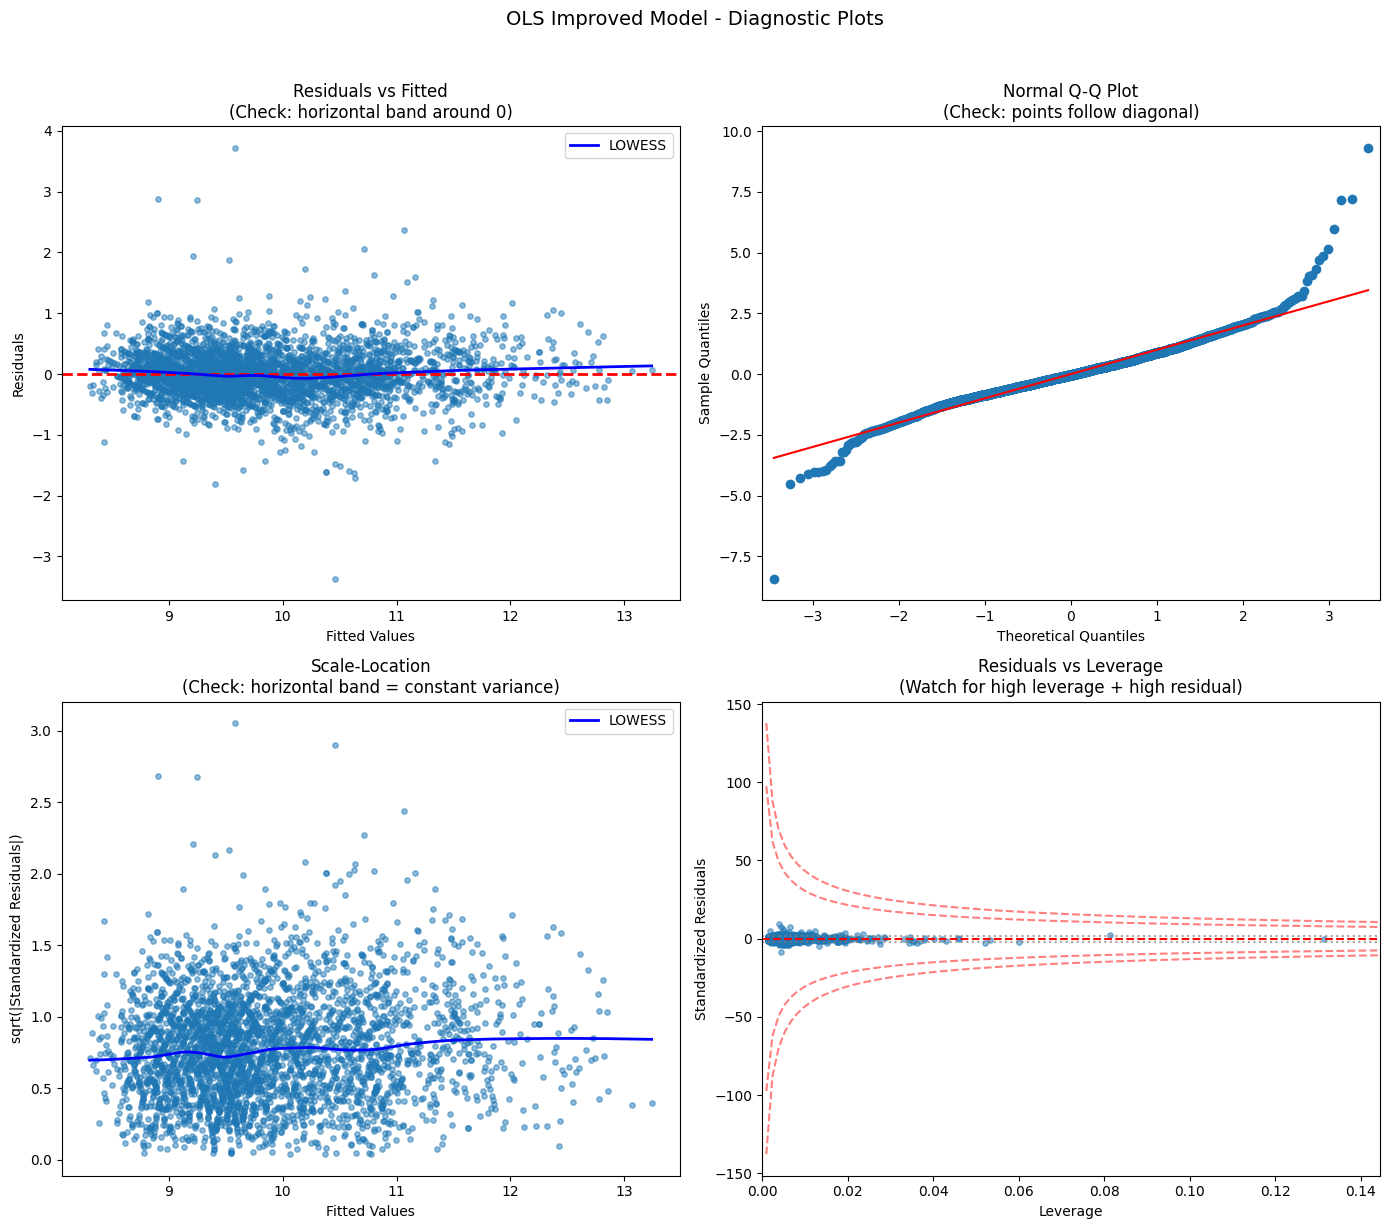


Diagnostic Summary:
  Residuals mean: -0.000000 (should be ~0)
  Residuals std: 0.3994
  Skewness: 0.3985 (should be ~0)
  Kurtosis: 6.4650 (should be ~0 for normal)


In [53]:
# Get influence measures from improved model
influence = model_improved.get_influence()

# Extract diagnostic measures
fitted_values = model_improved.fittedvalues
residuals = model_improved.resid
standardized_resid = influence.resid_studentized_internal
cooks_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag

# 4-panel diagnostic plot (similar to R's plot.lm)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Residuals vs Fitted (Linearity check)
axes[0, 0].scatter(fitted_values, residuals, alpha=0.5, s=15)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
# Add lowess smoother
from statsmodels.nonparametric.smoothers_lowess import lowess
lowess_line = lowess(residuals, fitted_values, frac=0.3)
axes[0, 0].plot(lowess_line[:, 0], lowess_line[:, 1], color='blue', linewidth=2, label='LOWESS')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted\n(Check: horizontal band around 0)')
axes[0, 0].legend()

# 2. Q-Q Plot (Normality check)
sm.qqplot(standardized_resid, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot\n(Check: points follow diagonal)')

# 3. Scale-Location (Homoscedasticity check)
sqrt_abs_resid = np.sqrt(np.abs(standardized_resid))
axes[1, 0].scatter(fitted_values, sqrt_abs_resid, alpha=0.5, s=15)
lowess_scale = lowess(sqrt_abs_resid, fitted_values, frac=0.3)
axes[1, 0].plot(lowess_scale[:, 0], lowess_scale[:, 1], color='blue', linewidth=2, label='LOWESS')
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('sqrt(|Standardized Residuals|)')
axes[1, 0].set_title('Scale-Location\n(Check: horizontal band = constant variance)')
axes[1, 0].legend()

# 4. Residuals vs Leverage (Influential observations)
axes[1, 1].scatter(leverage, standardized_resid, alpha=0.5, s=15)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].axhline(-2, color='gray', linestyle=':', alpha=0.7)
axes[1, 1].axhline(2, color='gray', linestyle=':', alpha=0.7)

# Add Cook's distance contours
n = len(fitted_values)
p = model_improved.df_model + 1
x_range = np.linspace(0.001, max(leverage) * 1.1, 100)
for cook_val in [0.5, 1.0]:
    y_cook = np.sqrt(cook_val * p * (1 - x_range) / x_range)
    axes[1, 1].plot(x_range, y_cook, 'r--', alpha=0.5, label=f"Cook's D = {cook_val}" if cook_val == 0.5 else None)
    axes[1, 1].plot(x_range, -y_cook, 'r--', alpha=0.5)

axes[1, 1].set_xlabel('Leverage')
axes[1, 1].set_ylabel('Standardized Residuals')
axes[1, 1].set_title('Residuals vs Leverage\n(Watch for high leverage + high residual)')
axes[1, 1].set_xlim(0, max(leverage) * 1.1)

plt.suptitle('OLS Improved Model - Diagnostic Plots', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print diagnostic summary
print("\nDiagnostic Summary:")
print(f"  Residuals mean: {residuals.mean():.6f} (should be ~0)")
print(f"  Residuals std: {residuals.std():.4f}")
print(f"  Skewness: {pd.Series(residuals).skew():.4f} (should be ~0)")
print(f"  Kurtosis: {pd.Series(residuals).kurtosis():.4f} (should be ~0 for normal)")

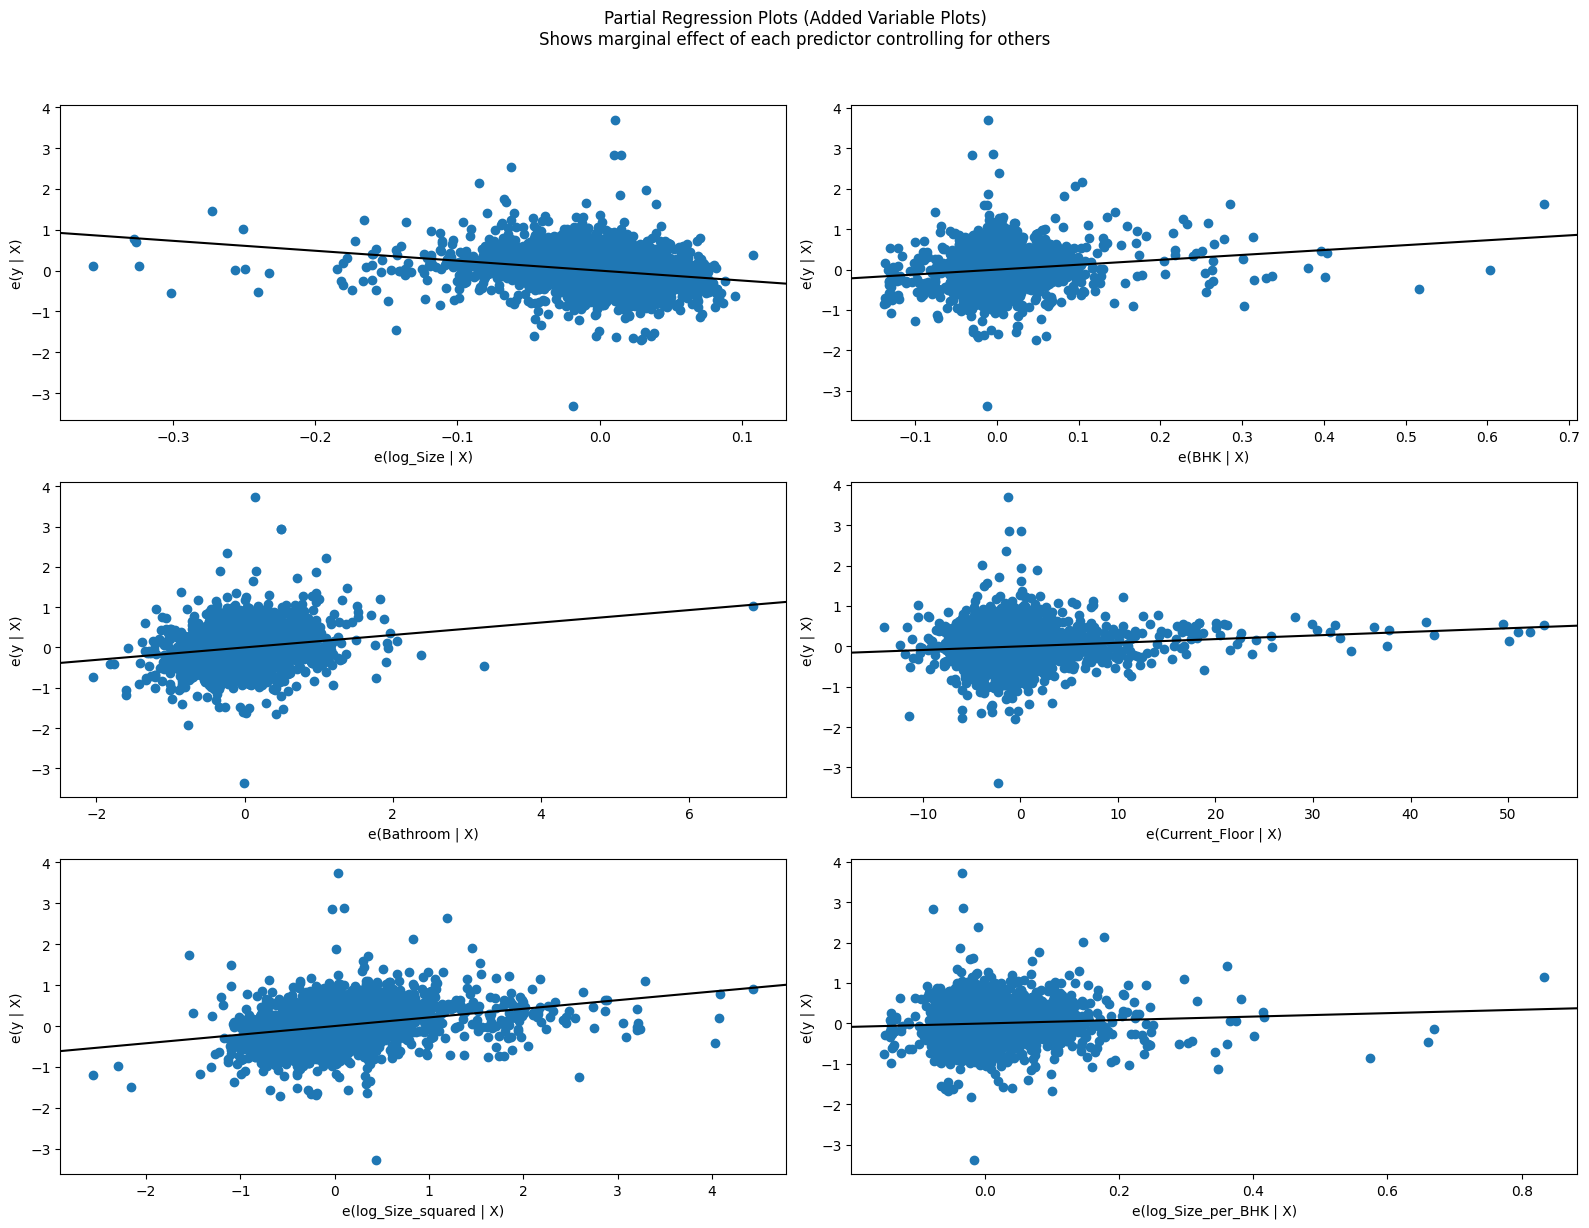

In [54]:
# Partial Regression Plots (Added Variable Plots)
# Show the relationship between each predictor and response, controlling for other predictors

from statsmodels.graphics.regressionplots import plot_partregress_grid

# Select key numerical features for partial regression plots
key_features = ['log_Size', 'BHK', 'Bathroom', 'Current_Floor', 'log_Size_squared', 'log_Size_per_BHK']

# Create partial regression plots for key features
fig = plt.figure(figsize=(16, 12))
plot_partregress_grid(model_improved, exog_idx=key_features, fig=fig)
plt.suptitle('Partial Regression Plots (Added Variable Plots)\nShows marginal effect of each predictor controlling for others',
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

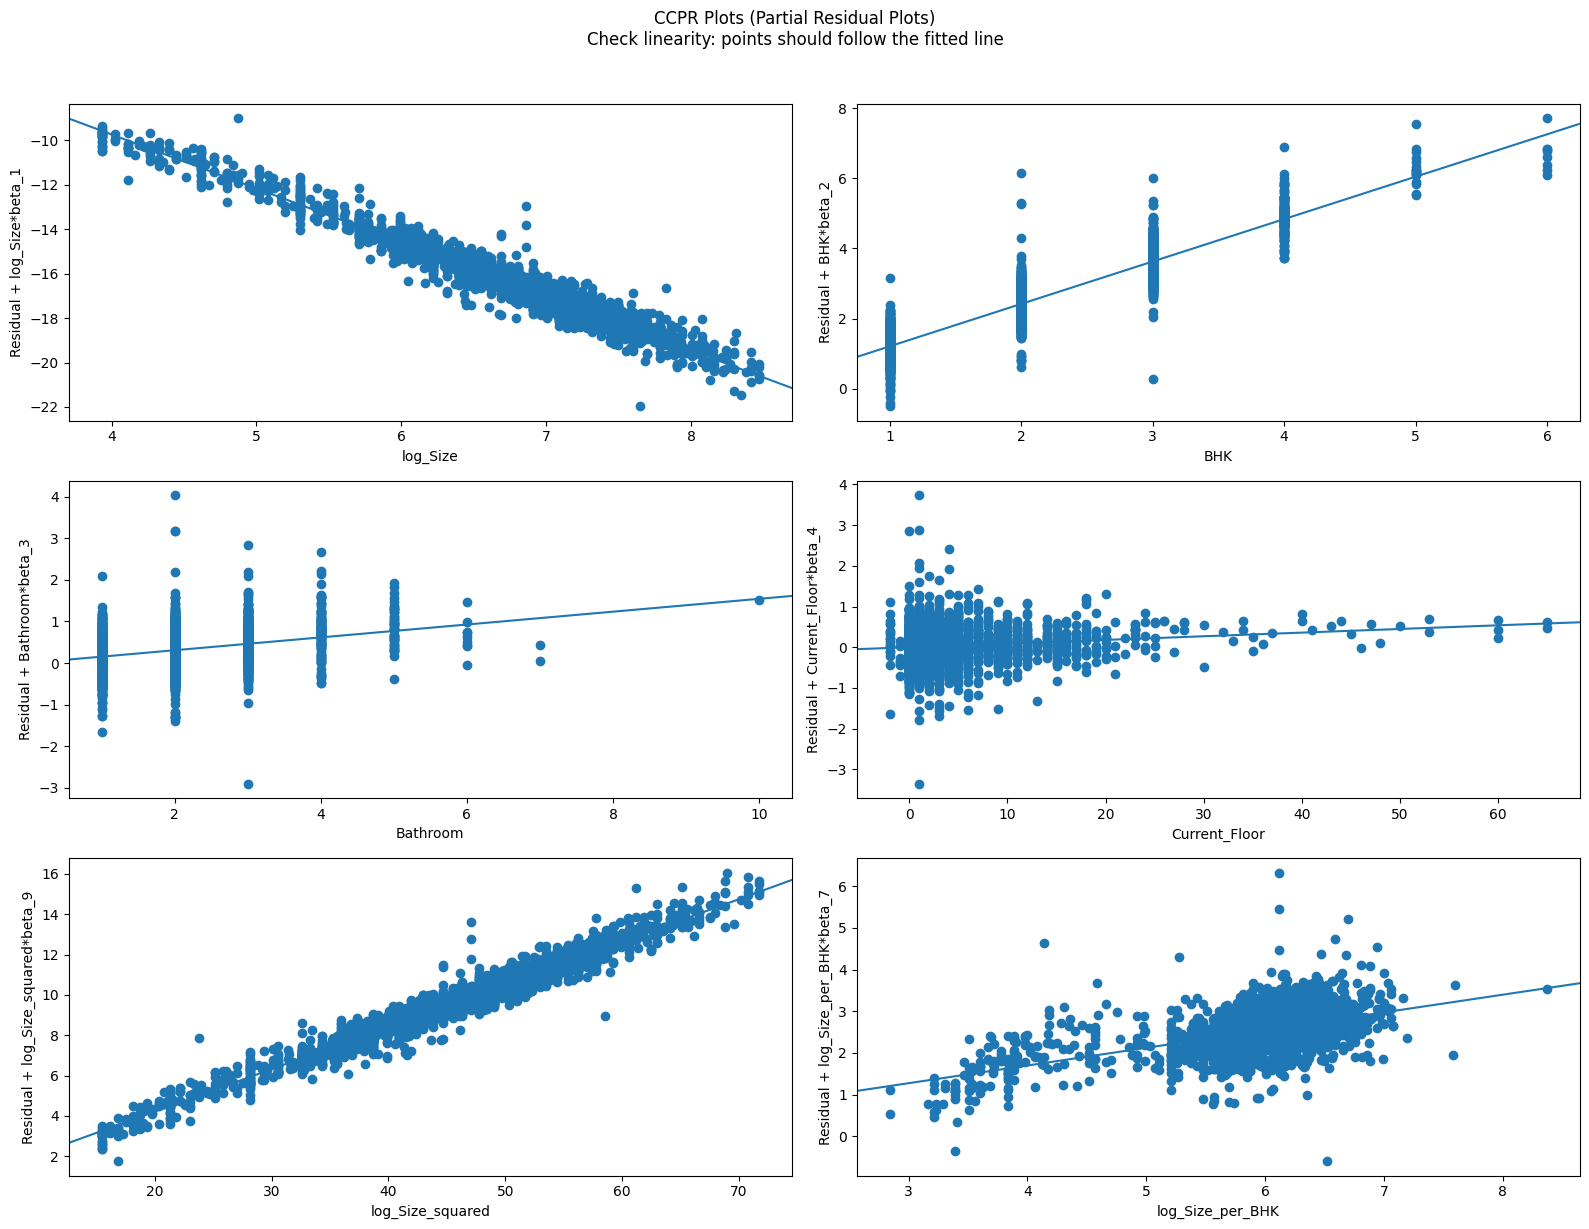

In [55]:
# Component-Component Plus Residual (CCPR) Plots
# Also known as Partial Residual Plots - check linearity assumption for each predictor

from statsmodels.graphics.regressionplots import plot_ccpr_grid

fig = plt.figure(figsize=(16, 12))
plot_ccpr_grid(model_improved, exog_idx=key_features, fig=fig)
plt.suptitle('CCPR Plots (Partial Residual Plots)\nCheck linearity: points should follow the fitted line',
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [56]:
# Influence Measures Summary
influence_summary = influence.summary_frame()

# Thresholds
n = len(y_train_arr)
p = model_improved.df_model + 1
cooks_threshold = 4 / n
leverage_threshold = 2 * p / n
dffits_threshold = 2 * np.sqrt(p / n)

print("Influence Measures Thresholds:")
print(f"  Cook's Distance threshold (4/n): {cooks_threshold:.4f}")
print(f"  Leverage threshold (2p/n): {leverage_threshold:.4f}")
print(f"  DFFITS threshold (2*sqrt(p/n)): {dffits_threshold:.4f}")

# Count influential observations
n_high_cooks = (cooks_d > cooks_threshold).sum()
n_high_leverage = (leverage > leverage_threshold).sum()
n_high_dffits = (np.abs(influence_summary['dffits']) > dffits_threshold).sum()

print(f"\nInfluential Observations:")
print(f"  High Cook's D (> {cooks_threshold:.4f}): {n_high_cooks} ({100*n_high_cooks/n:.1f}%)")
print(f"  High Leverage (> {leverage_threshold:.4f}): {n_high_leverage} ({100*n_high_leverage/n:.1f}%)")
print(f"  High |DFFITS| (> {dffits_threshold:.4f}): {n_high_dffits} ({100*n_high_dffits/n:.1f}%)")

# Show top influential observations
top_influential = influence_summary.nlargest(10, 'cooks_d')[['cooks_d', 'dffits', 'hat_diag', 'student_resid']]
print(f"\nTop 10 observations by Cook's Distance:")
print(top_influential.to_string())

Influence Measures Thresholds:
  Cook's Distance threshold (4/n): 0.0011
  Leverage threshold (2p/n): 0.0107
  DFFITS threshold (2*sqrt(p/n)): 0.1461

Influential Observations:
  High Cook's D (> 0.0011): 187 (5.3%)
  High Leverage (> 0.0107): 181 (5.1%)
  High |DFFITS| (> 0.1461): 219 (6.2%)

Top 10 observations by Cook's Distance:
       cooks_d    dffits  hat_diag  student_resid
3254  0.021119 -0.666629  0.052059      -2.844629
398   0.018426  0.622351  0.081484       2.089503
778   0.016396  0.591036  0.006607       7.247352
2294  0.016380  0.593750  0.003946       9.433383
1973  0.015846  0.578961  0.012354       5.176595
2904  0.015314 -0.572785  0.004512      -8.508237
3275  0.014447 -0.551401  0.034385      -2.922031
799   0.014010 -0.543144  0.027474      -3.231493
317   0.013726  0.537927  0.019314       3.833121
1374  0.013194 -0.527838  0.013316      -4.543705


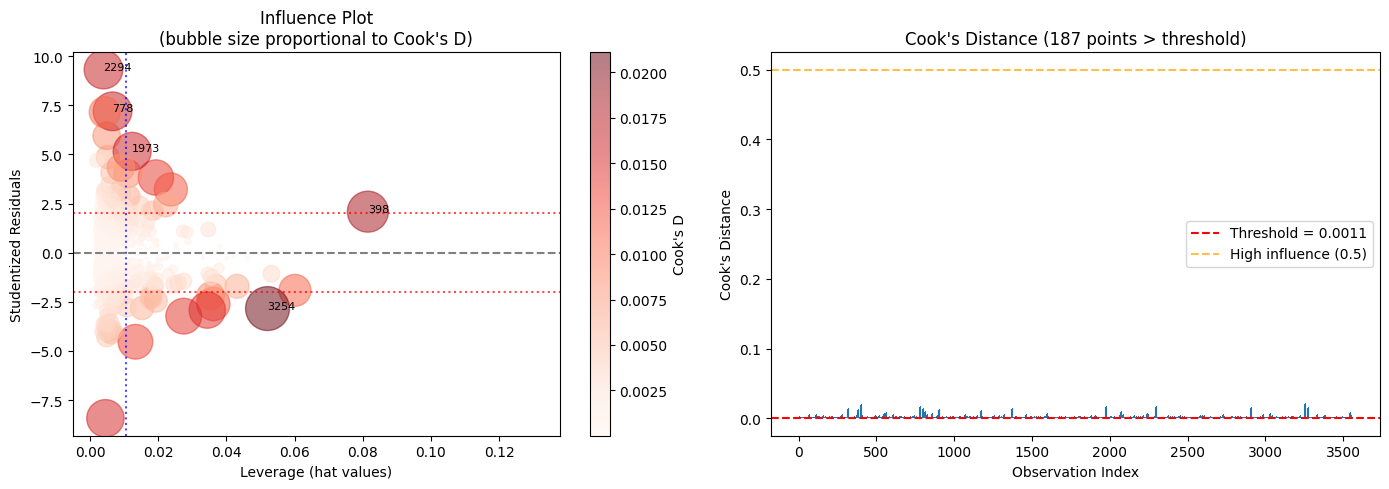

In [57]:
# Influence Plot - bubble size = Cook's distance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Leverage vs Studentized Residuals
bubble_size = 1000 * cooks_d / cooks_d.max()
scatter = axes[0].scatter(leverage, standardized_resid, s=bubble_size, alpha=0.5, c=cooks_d, cmap='Reds')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].axhline(-2, color='red', linestyle=':', alpha=0.7)
axes[0].axhline(2, color='red', linestyle=':', alpha=0.7)
axes[0].axvline(leverage_threshold, color='blue', linestyle=':', alpha=0.7)
axes[0].set_xlabel('Leverage (hat values)')
axes[0].set_ylabel('Studentized Residuals')
axes[0].set_title("Influence Plot\n(bubble size proportional to Cook's D)")
plt.colorbar(scatter, ax=axes[0], label="Cook's D")

# Annotate top influential points
top_cooks_idx = np.argsort(cooks_d)[-5:]
for idx in top_cooks_idx:
    if cooks_d[idx] > cooks_threshold:
        axes[0].annotate(str(idx), (leverage[idx], standardized_resid[idx]), fontsize=8)

# Plot 2: Cook's Distance stem plot
axes[1].stem(range(len(cooks_d)), cooks_d, markerfmt=',', basefmt=' ')
axes[1].axhline(cooks_threshold, color='red', linestyle='--', label=f'Threshold = {cooks_threshold:.4f}')
axes[1].axhline(0.5, color='orange', linestyle='--', alpha=0.7, label='High influence (0.5)')
axes[1].set_xlabel('Observation Index')
axes[1].set_ylabel("Cook's Distance")
axes[1].set_title(f"Cook's Distance ({n_high_cooks} points > threshold)")
axes[1].legend()

plt.tight_layout()
plt.show()

In [58]:
# Statistical Tests for Model Assumptions
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

print("="*70)
print("STATISTICAL TESTS FOR MODEL ASSUMPTIONS")
print("="*70)

# 1. Normality of Residuals
stat_shapiro, p_shapiro = stats.shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)
stat_jarque, p_jarque = stats.jarque_bera(residuals)[:2]

print("\n1. NORMALITY OF RESIDUALS")
print(f"   Shapiro-Wilk test: W = {stat_shapiro:.4f}, p-value = {p_shapiro:.4e}")
print(f"   Jarque-Bera test: JB = {stat_jarque:.4f}, p-value = {p_jarque:.4e}")
if p_jarque < 0.05:
    print("   -> Residuals appear non-normal (p < 0.05)")
else:
    print("   -> Residuals appear normal")

# 2. Homoscedasticity (Breusch-Pagan test)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X_train_improved)

print("\n2. HOMOSCEDASTICITY (Constant Variance)")
print(f"   Breusch-Pagan test: LM = {bp_stat:.4f}, p-value = {bp_pvalue:.4e}")
if bp_pvalue < 0.05:
    print("   -> Heteroscedasticity detected (p < 0.05)")
else:
    print("   -> Homoscedasticity assumption holds")

# 3. Autocorrelation (Durbin-Watson)
dw_stat = durbin_watson(residuals)

print("\n3. AUTOCORRELATION")
print(f"   Durbin-Watson statistic: {dw_stat:.4f}")
if 1.5 < dw_stat < 2.5:
    print("   -> No autocorrelation (DW close to 2)")
else:
    print("   -> Potential autocorrelation")

# 4. Linearity - RESET test (Ramsey)
from statsmodels.stats.diagnostic import linear_reset
reset_result = linear_reset(model_improved, power=2, use_f=True)

print("\n4. LINEARITY (Ramsey RESET test)")
print(f"   F-statistic: {reset_result.fvalue:.4f}, p-value: {reset_result.pvalue:.4e}")
if reset_result.pvalue < 0.05:
    print("   -> Model may be misspecified (p < 0.05)")
else:
    print("   -> Linear specification appears adequate")

print("\n" + "="*70)
print("INTERPRETATION NOTES:")
print("- Non-normality: Use robust standard errors or bootstrap")
print("- Heteroscedasticity: Use HC standard errors (model.get_robustcov_results())")
print("- The log transformation of rent helps address skewness")
print("="*70)

STATISTICAL TESTS FOR MODEL ASSUMPTIONS

1. NORMALITY OF RESIDUALS
   Shapiro-Wilk test: W = 0.9548, p-value = 7.5218e-32
   Jarque-Bera test: JB = 6271.5591, p-value = 0.0000e+00
   -> Residuals appear non-normal (p < 0.05)

2. HOMOSCEDASTICITY (Constant Variance)
   Breusch-Pagan test: LM = 82.0960, p-value = 1.7255e-09
   -> Heteroscedasticity detected (p < 0.05)

3. AUTOCORRELATION
   Durbin-Watson statistic: 1.9789
   -> No autocorrelation (DW close to 2)

4. LINEARITY (Ramsey RESET test)
   F-statistic: 60.0662, p-value: 1.1900e-14
   -> Model may be misspecified (p < 0.05)

INTERPRETATION NOTES:
- Non-normality: Use robust standard errors or bootstrap
- Heteroscedasticity: Use HC standard errors (model.get_robustcov_results())
- The log transformation of rent helps address skewness


### 5.3 Statsmodels OLS - Evaluation on Test Data

Compare metrics on log scale (transformed response) vs original scale.

In [59]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predictions on test data
y_pred_full_log = model_full.predict(X_test_sm)
y_pred_improved_log = model_improved.predict(X_test_improved)

# Transform back to original scale
y_pred_full_orig = np.expm1(y_pred_full_log)
y_pred_improved_orig = np.expm1(y_pred_improved_log)

print("="*80)
print("STATSMODELS OLS - TEST SET EVALUATION")
print("="*80)

# Metrics on LOG scale (transformed response)
print("--- Metrics on LOG scale (transformed response) ---")
print(f"{'Model':<20} {'R²':>10} {'RMSE':>12} {'MAE':>12}")
print("-"*56)

r2_full_log = r2_score(y_test_arr, y_pred_full_log)
rmse_full_log = np.sqrt(mean_squared_error(y_test_arr, y_pred_full_log))
mae_full_log = mean_absolute_error(y_test_arr, y_pred_full_log)
print(f"{'Full Model':<20} {r2_full_log:>10.4f} {rmse_full_log:>12.4f} {mae_full_log:>12.4f}")

r2_imp_log = r2_score(y_test_arr, y_pred_improved_log)
rmse_imp_log = np.sqrt(mean_squared_error(y_test_arr, y_pred_improved_log))
mae_imp_log = mean_absolute_error(y_test_arr, y_pred_improved_log)
print(f"{'Improved Model':<20} {r2_imp_log:>10.4f} {rmse_imp_log:>12.4f} {mae_imp_log:>12.4f}")

# Metrics on ORIGINAL scale
print("--- Metrics on ORIGINAL scale (back-transformed) ---")
print(f"{'Model':<20} {'R²':>10} {'RMSE (INR)':>15} {'MAE (INR)':>15} {'MAPE %':>10}")
print("-"*75)

# Use original values (need to align indices)
y_test_orig_arr = y_test_original.values

r2_full_orig = r2_score(y_test_orig_arr, y_pred_full_orig)
rmse_full_orig = np.sqrt(mean_squared_error(y_test_orig_arr, y_pred_full_orig))
mae_full_orig = mean_absolute_error(y_test_orig_arr, y_pred_full_orig)
mape_full = np.mean(np.abs((y_test_orig_arr - y_pred_full_orig) / y_test_orig_arr)) * 100
print(f"{'Full Model':<20} {r2_full_orig:>10.4f} {rmse_full_orig:>15,.0f} {mae_full_orig:>15,.0f} {mape_full:>10.1f}")

r2_imp_orig = r2_score(y_test_orig_arr, y_pred_improved_orig)
rmse_imp_orig = np.sqrt(mean_squared_error(y_test_orig_arr, y_pred_improved_orig))
mae_imp_orig = mean_absolute_error(y_test_orig_arr, y_pred_improved_orig)
mape_imp = np.mean(np.abs((y_test_orig_arr - y_pred_improved_orig) / y_test_orig_arr)) * 100
print(f"{'Improved Model':<20} {r2_imp_orig:>10.4f} {rmse_imp_orig:>15,.0f} {mae_imp_orig:>15,.0f} {mape_imp:>10.1f}")

print("="*80)
print("Note: R² on original scale is lower because extreme values are harder to predict.")
print("The log transformation helps the model learn better, but back-transformation")
print("amplifies errors for high-rent properties.")

STATSMODELS OLS - TEST SET EVALUATION
--- Metrics on LOG scale (transformed response) ---
Model                        R²         RMSE          MAE
--------------------------------------------------------
Full Model               0.8330       0.3853       0.2969
Improved Model           0.8313       0.3872       0.2989
--- Metrics on ORIGINAL scale (back-transformed) ---
Model                        R²      RMSE (INR)       MAE (INR)     MAPE %
---------------------------------------------------------------------------
Full Model               0.6741          35,214          11,505       30.7
Improved Model           0.6714          35,355          11,544       30.9
Note: R² on original scale is lower because extreme values are harder to predict.
The log transformation helps the model learn better, but back-transformation
amplifies errors for high-rent properties.


### 5.4 Sklearn Models - OLS, Ridge, Lasso, ElasticNet

Now train regularized models using sklearn with cross-validation for hyperparameter tuning.

In [60]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define alpha grid for regularization
alphas = np.logspace(-4, 2, 100)

# OLS (no regularization)
ols_model = LinearRegression()
ols_model.fit(X_train_final, y_train)
y_pred_ols = ols_model.predict(X_test_final)

# Ridge (L2 regularization)
ridge_model = RidgeCV(alphas=alphas, cv=5)
ridge_model.fit(X_train_final, y_train)
y_pred_ridge = ridge_model.predict(X_test_final)

# Lasso (L1 regularization - feature selection)
lasso_model = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)
lasso_model.fit(X_train_final, y_train)
y_pred_lasso = lasso_model.predict(X_test_final)

# ElasticNet (L1 + L2)
elastic_model = ElasticNetCV(
    alphas=alphas,
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.99],
    cv=5,
    random_state=42,
    max_iter=10000
)
elastic_model.fit(X_train_final, y_train)
y_pred_elastic = elastic_model.predict(X_test_final)

print("Models trained successfully!")
print(f"\nRegularization parameters:")
print(f"  Ridge alpha: {ridge_model.alpha_:.4f}")
print(f"  Lasso alpha: {lasso_model.alpha_:.6f}")
print(f"  ElasticNet alpha: {elastic_model.alpha_:.6f}, l1_ratio: {elastic_model.l1_ratio_:.2f}")
print(f"\nLasso non-zero coefficients: {np.sum(lasso_model.coef_ != 0)} / {len(lasso_model.coef_)}")

Models trained successfully!

Regularization parameters:
  Ridge alpha: 0.0050
  Lasso alpha: 0.000100
  ElasticNet alpha: 0.000100, l1_ratio: 0.99

Lasso non-zero coefficients: 25 / 28


## 6. Model Evaluation

**Critical**: We evaluate on ORIGINAL (non-clipped) rent values!

The models are trained on log(Rent_capped), but final R² is computed on original Rent.

In [61]:
# Transform predictions back to original scale
# Note: We use expm1() which is the inverse of log1p()

# Include both statsmodels and sklearn models
models = {
    'SM OLS Full': y_pred_full_log,
    'SM OLS Improved': y_pred_improved_log,
    'sklearn OLS': y_pred_ols,
    'Ridge': y_pred_ridge,
    'Lasso': y_pred_lasso,
    'ElasticNet': y_pred_elastic
}

print("="*90)
print("ALL MODELS - COMPARISON ON TEST SET")
print("="*90)
print("Note: R² is computed against ORIGINAL (non-clipped) test rent values!")
print(f"Test set original Rent range: {y_test_original.min():,} - {y_test_original.max():,} INR")

results = []
for name, y_pred_log in models.items():
    # Transform predictions back to original scale
    y_pred_orig = np.expm1(y_pred_log)

    # Compute metrics against ORIGINAL rent (not clipped!)
    r2_orig = r2_score(y_test_orig_arr, y_pred_orig)
    rmse_orig = np.sqrt(mean_squared_error(y_test_orig_arr, y_pred_orig))
    mae_orig = mean_absolute_error(y_test_orig_arr, y_pred_orig)
    mape = np.mean(np.abs((y_test_orig_arr - y_pred_orig) / y_test_orig_arr)) * 100

    # Also compute R² on log scale for comparison
    r2_log = r2_score(y_test_arr, y_pred_log)

    results.append([name, r2_log, r2_orig, rmse_orig, mae_orig, mape])

results_df = pd.DataFrame(results,
    columns=['Model', 'R² (log)', 'R² (ORIGINAL)', 'RMSE (INR)', 'MAE (INR)', 'MAPE %']
)
results_df = results_df.sort_values('R² (ORIGINAL)', ascending=False)

print(results_df.to_string(index=False))
print("="*90)

# Best model by R² on original scale
best = results_df.iloc[0]
print(f"*** BEST MODEL: {best['Model']} ***")
print(f"    R² (log scale): {best['R² (log)']:.4f}")
print(f"    R² (Original Scale): {best['R² (ORIGINAL)']:.4f}")
print(f"    RMSE: {best['RMSE (INR)']:,.0f} INR")
print(f"    MAE: {best['MAE (INR)']:,.0f} INR")
print(f"    MAPE: {best['MAPE %']:.1f}%")

ALL MODELS - COMPARISON ON TEST SET
Note: R² is computed against ORIGINAL (non-clipped) test rent values!
Test set original Rent range: 1,800 - 1,200,000 INR
          Model  R² (log)  R² (ORIGINAL)   RMSE (INR)    MAE (INR)    MAPE %
    sklearn OLS  0.833006       0.674071 35214.001229 11504.893509 30.721815
    SM OLS Full  0.833006       0.674071 35214.001229 11504.893509 30.721815
          Ridge  0.833010       0.673990 35218.397231 11505.805436 30.721754
SM OLS Improved  0.831350       0.671447 35355.488112 11544.277320 30.905178
          Lasso  0.833093       0.671205 35368.481784 11548.929865 30.737620
     ElasticNet  0.833092       0.671179 35369.866577 11549.234569 30.737776
*** BEST MODEL: sklearn OLS ***
    R² (log scale): 0.8330
    R² (Original Scale): 0.6741
    RMSE: 35,214 INR
    MAE: 11,505 INR
    MAPE: 30.7%


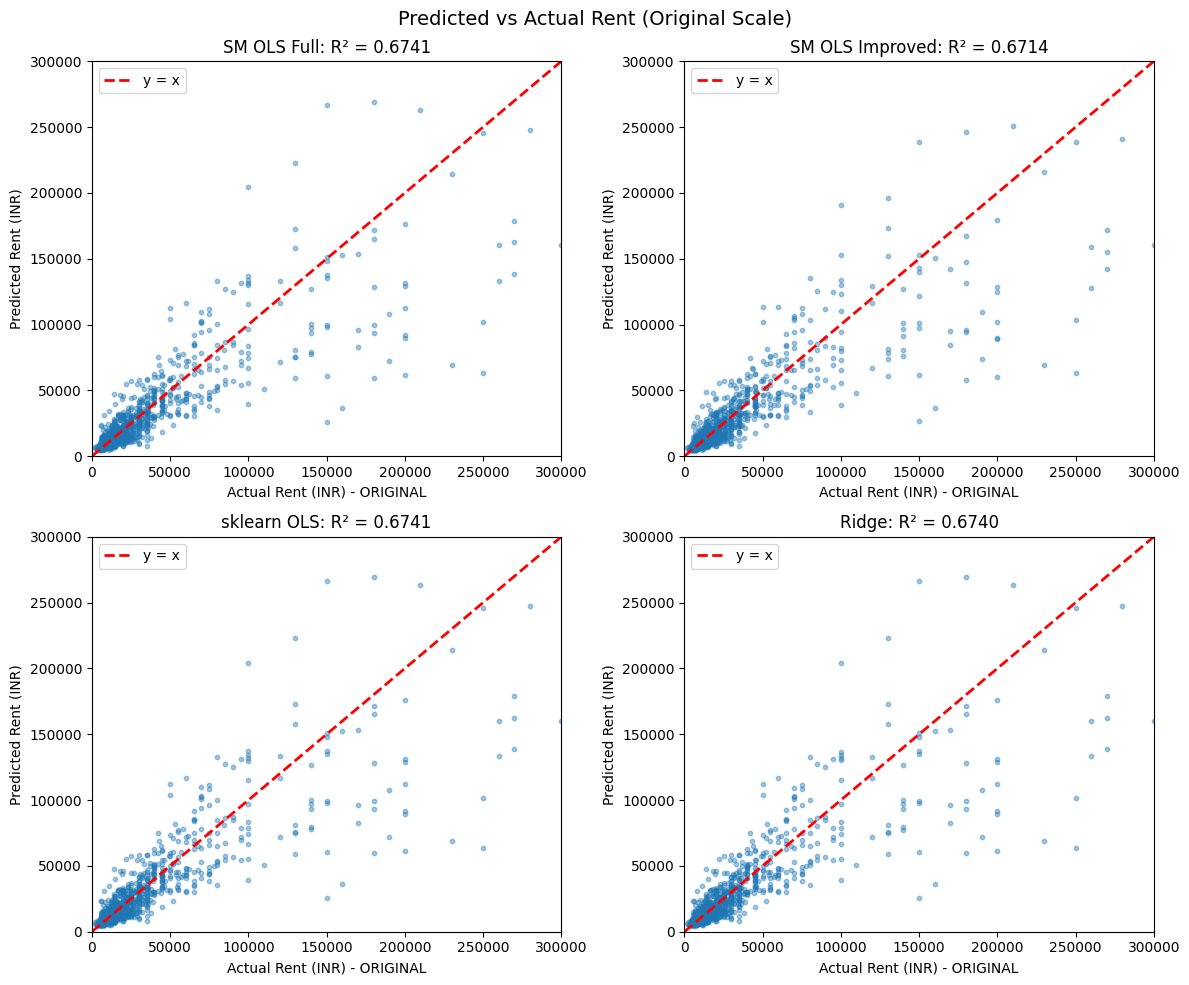

In [62]:
# Predicted vs Actual plots (on original scale)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, y_pred_log) in zip(axes.flatten(), models.items()):
    y_pred_orig = np.expm1(y_pred_log)
    r2 = r2_score(y_test_original, y_pred_orig)

    ax.scatter(y_test_original, y_pred_orig, alpha=0.4, s=10)
    max_val = 300000
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='y = x')
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('Actual Rent (INR) - ORIGINAL')
    ax.set_ylabel('Predicted Rent (INR)')
    ax.set_title(f'{name}: R² = {r2:.4f}')
    ax.legend()

plt.suptitle('Predicted vs Actual Rent (Original Scale)', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Model Diagnostics

Check regression assumptions using residual analysis.

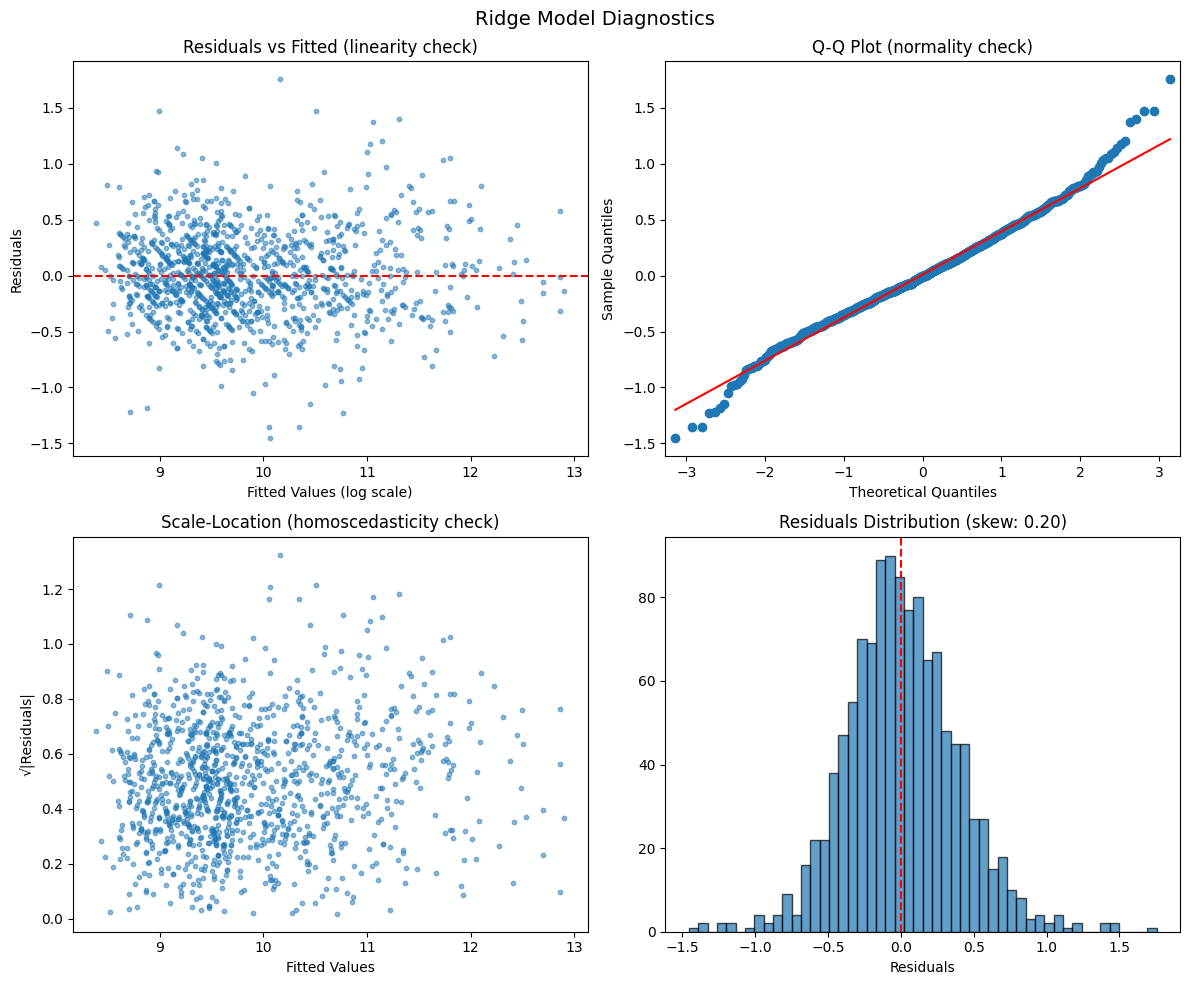

In [63]:
# Residual analysis for Ridge model
residuals = y_test.values - y_pred_ridge
fitted = y_pred_ridge

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(fitted, residuals, alpha=0.5, s=10)
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values (log scale)')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (linearity check)')

# 2. Q-Q plot
import statsmodels.api as sm
sm.qqplot(residuals, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (normality check)')

# 3. Scale-Location plot
axes[1, 0].scatter(fitted, np.sqrt(np.abs(residuals)), alpha=0.5, s=10)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('√|Residuals|')
axes[1, 0].set_title('Scale-Location (homoscedasticity check)')

# 4. Residuals histogram
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_title(f'Residuals Distribution (skew: {pd.Series(residuals).skew():.2f})')

plt.suptitle('Ridge Model Diagnostics', fontsize=14)
plt.tight_layout()
plt.show()

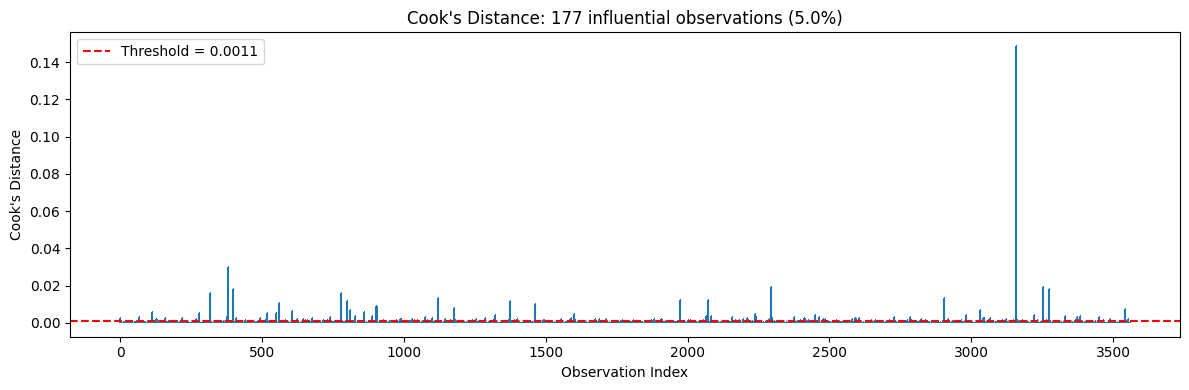

In [64]:
# Influential observations (Cook's distance) - on training data
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train_final)
ols_sm = sm.OLS(y_train, X_train_sm).fit()
influence = ols_sm.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(y_train)
n_influential = np.sum(cooks_d > threshold)

plt.figure(figsize=(12, 4))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=',', basefmt=' ')
plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title(f"Cook's Distance: {n_influential} influential observations ({100*n_influential/len(y_train):.1f}%)")
plt.legend()
plt.tight_layout()
plt.show()

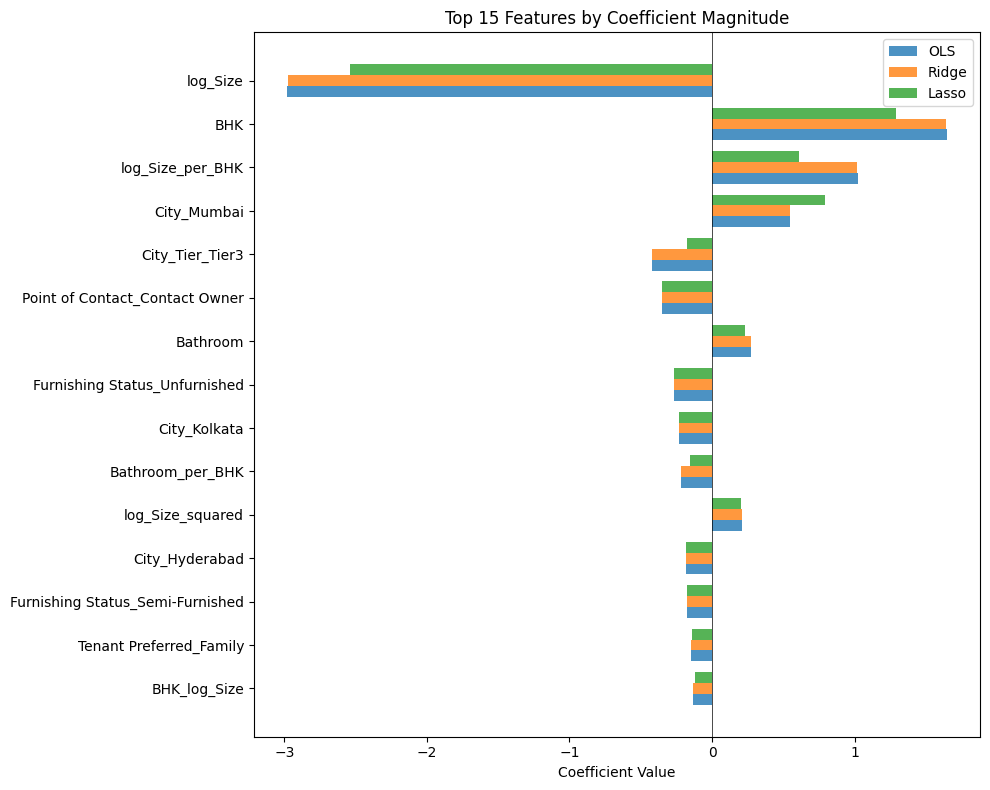

In [65]:
# Feature importance comparison
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'OLS': ols_model.coef_,
    'Ridge': ridge_model.coef_,
    'Lasso': lasso_model.coef_
})

# Top 15 features by Ridge coefficient magnitude
top_idx = np.argsort(np.abs(coef_df['Ridge']))[-15:]
top_features = coef_df.iloc[top_idx].sort_values('Ridge', key=abs, ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(top_features))
width = 0.25

ax.barh(y_pos - width, top_features['OLS'], width, label='OLS', alpha=0.8)
ax.barh(y_pos, top_features['Ridge'], width, label='Ridge', alpha=0.8)
ax.barh(y_pos + width, top_features['Lasso'], width, label='Lasso', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Coefficient Value')
ax.set_title('Top 15 Features by Coefficient Magnitude')
ax.legend()
ax.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

## 8. Gradient Boosting Comparison

Compare linear models with HistGradientBoostingRegressor:
1. **GBD on engineered features** - using the same feature-engineered dataset as OLS
2. **GBD on original features** - using only the original dataset features

Use Optuna for hyperparameter tuning to find optimal parameters.

In [66]:
# Install optuna if not available
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
except ImportError:
    %pip install -q optuna
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score
print(f"Optuna version: {optuna.__version__}")

Optuna version: 4.5.0


In [67]:
# HistGradientBoostingRegressor on ENGINEERED features
# Using Optuna for hyperparameter optimization

def objective_engineered(trial):
    """Objective function for Optuna - engineered features."""
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_iter': trial.suggest_int('max_iter', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 127),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-6, 10, log=True),
        'random_state': 42
    }

    model = HistGradientBoostingRegressor(**params)
    # Use cross-validation on training data
    scores = cross_val_score(model, X_train_final, y_train_arr, cv=5, scoring='r2')
    return scores.mean()

print("Optimizing HistGradientBoostingRegressor on ENGINEERED features...")
print("This may take a few minutes...")

study_eng = optuna.create_study(direction='maximize', study_name='gbd_engineered')
study_eng.optimize(objective_engineered, n_trials=50, show_progress_bar=True)

print(f"\nBest CV R² (engineered): {study_eng.best_value:.4f}")
print(f"Best parameters:")
for key, value in study_eng.best_params.items():
    print(f"  {key}: {value}")

Optimizing HistGradientBoostingRegressor on ENGINEERED features...
This may take a few minutes...


  0%|          | 0/50 [00:00<?, ?it/s]


Best CV R² (engineered): 0.8249
Best parameters:
  learning_rate: 0.024880073795279997
  max_iter: 249
  max_depth: 12
  min_samples_leaf: 50
  max_leaf_nodes: 24
  l2_regularization: 0.0004385392257974902


In [68]:
# Train final model with best parameters on engineered features
gbd_eng_best = HistGradientBoostingRegressor(**study_eng.best_params, random_state=42)
gbd_eng_best.fit(X_train_final, y_train_arr)

# Predictions
y_pred_gbd_eng_log = gbd_eng_best.predict(X_test_final)
y_pred_gbd_eng_orig = np.expm1(y_pred_gbd_eng_log)

# Metrics
r2_gbd_eng_log = r2_score(y_test_arr, y_pred_gbd_eng_log)
r2_gbd_eng_orig = r2_score(y_test_orig_arr, y_pred_gbd_eng_orig)
rmse_gbd_eng = np.sqrt(mean_squared_error(y_test_orig_arr, y_pred_gbd_eng_orig))
mae_gbd_eng = mean_absolute_error(y_test_orig_arr, y_pred_gbd_eng_orig)

print("GBD on Engineered Features - Test Set Results:")
print(f"  R² (log scale): {r2_gbd_eng_log:.4f}")
print(f"  R² (original scale): {r2_gbd_eng_orig:.4f}")
print(f"  RMSE: {rmse_gbd_eng:,.0f} INR")
print(f"  MAE: {mae_gbd_eng:,.0f} INR")

GBD on Engineered Features - Test Set Results:
  R² (log scale): 0.8493
  R² (original scale): 0.7026
  RMSE: 33,637 INR
  MAE: 10,714 INR


In [69]:
# Prepare ORIGINAL features dataset (minimal preprocessing)
# Only use features available in the original dataset

# Original numerical features
original_num_features = ['Size', 'BHK', 'Bathroom']

# Original categorical features
original_cat_features = ['City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact', 'Area Type']

# Prepare train data with original features
X_train_orig_num = train_df[original_num_features].values
X_test_orig_num = test_df[original_num_features].values

# One-hot encode categorical features (fit on train)
encoder_orig = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
encoder_orig.fit(train_df[original_cat_features])

X_train_orig_cat = encoder_orig.transform(train_df[original_cat_features])
X_test_orig_cat = encoder_orig.transform(test_df[original_cat_features])

# Combine
X_train_orig_all = np.hstack([X_train_orig_num, X_train_orig_cat])
X_test_orig_all = np.hstack([X_test_orig_num, X_test_orig_cat])

# Target: log of ORIGINAL rent (not capped) for fair comparison
y_train_log_orig = np.log1p(y_train_original.values)
y_test_log_orig = np.log1p(y_test_original.values)

print(f"Original features dataset:")
print(f"  X_train shape: {X_train_orig_all.shape}")
print(f"  X_test shape: {X_test_orig_all.shape}")
print(f"  Numerical features: {original_num_features}")
print(f"  Categorical features: {original_cat_features}")

Original features dataset:
  X_train shape: (3559, 15)
  X_test shape: (1187, 15)
  Numerical features: ['Size', 'BHK', 'Bathroom']
  Categorical features: ['City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact', 'Area Type']


In [70]:
# HistGradientBoostingRegressor on ORIGINAL features
# Using Optuna for hyperparameter optimization

def objective_original(trial):
    """Objective function for Optuna - original features."""
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_iter': trial.suggest_int('max_iter', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 127),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-6, 10, log=True),
        'random_state': 42
    }

    model = HistGradientBoostingRegressor(**params)
    scores = cross_val_score(model, X_train_orig_all, y_train_log_orig, cv=5, scoring='r2')
    return scores.mean()

print("Optimizing HistGradientBoostingRegressor on ORIGINAL features...")
print("This may take a few minutes...")

study_orig = optuna.create_study(direction='maximize', study_name='gbd_original')
study_orig.optimize(objective_original, n_trials=50, show_progress_bar=True)

print(f"\nBest CV R² (original): {study_orig.best_value:.4f}")
print(f"Best parameters:")
for key, value in study_orig.best_params.items():
    print(f"  {key}: {value}")

Optimizing HistGradientBoostingRegressor on ORIGINAL features...
This may take a few minutes...


  0%|          | 0/50 [00:00<?, ?it/s]


Best CV R² (original): 0.8185
Best parameters:
  learning_rate: 0.1768871640757922
  max_iter: 99
  max_depth: 3
  min_samples_leaf: 13
  max_leaf_nodes: 33
  l2_regularization: 0.0005803574060125611


In [71]:
# Train final model with best parameters on original features
gbd_orig_best = HistGradientBoostingRegressor(**study_orig.best_params, random_state=42)
gbd_orig_best.fit(X_train_orig_all, y_train_log_orig)

# Predictions
y_pred_gbd_orig_log = gbd_orig_best.predict(X_test_orig_all)
y_pred_gbd_orig_orig = np.expm1(y_pred_gbd_orig_log)

# Metrics
r2_gbd_orig_log = r2_score(y_test_log_orig, y_pred_gbd_orig_log)
r2_gbd_orig_orig = r2_score(y_test_orig_arr, y_pred_gbd_orig_orig)
rmse_gbd_orig = np.sqrt(mean_squared_error(y_test_orig_arr, y_pred_gbd_orig_orig))
mae_gbd_orig = mean_absolute_error(y_test_orig_arr, y_pred_gbd_orig_orig)

print("GBD on Original Features - Test Set Results:")
print(f"  R² (log scale): {r2_gbd_orig_log:.4f}")
print(f"  R² (original scale): {r2_gbd_orig_orig:.4f}")
print(f"  RMSE: {rmse_gbd_orig:,.0f} INR")
print(f"  MAE: {mae_gbd_orig:,.0f} INR")

GBD on Original Features - Test Set Results:
  R² (log scale): 0.8416
  R² (original scale): 0.7366
  RMSE: 31,657 INR
  MAE: 11,222 INR


In [72]:
# FINAL COMPARISON: OLS vs Gradient Boosting

print("="*100)
print("FINAL MODEL COMPARISON: Linear Models vs Gradient Boosting")
print("="*100)
print("\nAll metrics computed on ORIGINAL (non-clipped) test rent values")
print(f"Test set size: {len(y_test_orig_arr)} samples\n")

# Collect all results
final_comparison = [
    ['SM OLS Full', r2_full_log, r2_full_orig, rmse_full_orig, mae_full_orig],
    ['SM OLS Improved', r2_imp_log, r2_imp_orig, rmse_imp_orig, mae_imp_orig],
    ['sklearn Ridge', r2_score(y_test_arr, y_pred_ridge), r2_score(y_test_orig_arr, np.expm1(y_pred_ridge)),
     np.sqrt(mean_squared_error(y_test_orig_arr, np.expm1(y_pred_ridge))),
     mean_absolute_error(y_test_orig_arr, np.expm1(y_pred_ridge))],
    ['GBD (Engineered)', r2_gbd_eng_log, r2_gbd_eng_orig, rmse_gbd_eng, mae_gbd_eng],
    ['GBD (Original)', r2_gbd_orig_log, r2_gbd_orig_orig, rmse_gbd_orig, mae_gbd_orig],
]

final_df = pd.DataFrame(final_comparison,
    columns=['Model', 'R² (log)', 'R² (ORIGINAL)', 'RMSE (INR)', 'MAE (INR)'])
final_df = final_df.sort_values('R² (ORIGINAL)', ascending=False)

print(final_df.to_string(index=False))
print("="*100)

# Highlight improvements
best_linear = max(r2_full_orig, r2_imp_orig, r2_score(y_test_orig_arr, np.expm1(y_pred_ridge)))
best_gbd = max(r2_gbd_eng_orig, r2_gbd_orig_orig)

print(f"\nKEY FINDINGS:")
print(f"  Best Linear Model R²: {best_linear:.4f}")
print(f"  Best GBD Model R²: {best_gbd:.4f}")
print(f"  Improvement: {(best_gbd - best_linear):.4f} ({100*(best_gbd - best_linear)/best_linear:.1f}%)")

if r2_gbd_eng_orig > r2_gbd_orig_orig:
    print(f"\n  -> Feature engineering helps GBD too!")
    print(f"     GBD(engineered) - GBD(original) = {r2_gbd_eng_orig - r2_gbd_orig_orig:.4f}")
else:
    print(f"\n  -> GBD on original features performs equally well")
    print(f"     Feature engineering may not be necessary for tree-based models")

FINAL MODEL COMPARISON: Linear Models vs Gradient Boosting

All metrics computed on ORIGINAL (non-clipped) test rent values
Test set size: 1187 samples

           Model  R² (log)  R² (ORIGINAL)   RMSE (INR)    MAE (INR)
  GBD (Original)  0.841616       0.736585 31657.330781 11221.926751
GBD (Engineered)  0.849349       0.702604 33637.292506 10714.279965
     SM OLS Full  0.833006       0.674071 35214.001229 11504.893509
   sklearn Ridge  0.833010       0.673990 35218.397231 11505.805436
 SM OLS Improved  0.831350       0.671447 35355.488112 11544.277320

KEY FINDINGS:
  Best Linear Model R²: 0.6741
  Best GBD Model R²: 0.7366
  Improvement: 0.0625 (9.3%)

  -> GBD on original features performs equally well
     Feature engineering may not be necessary for tree-based models


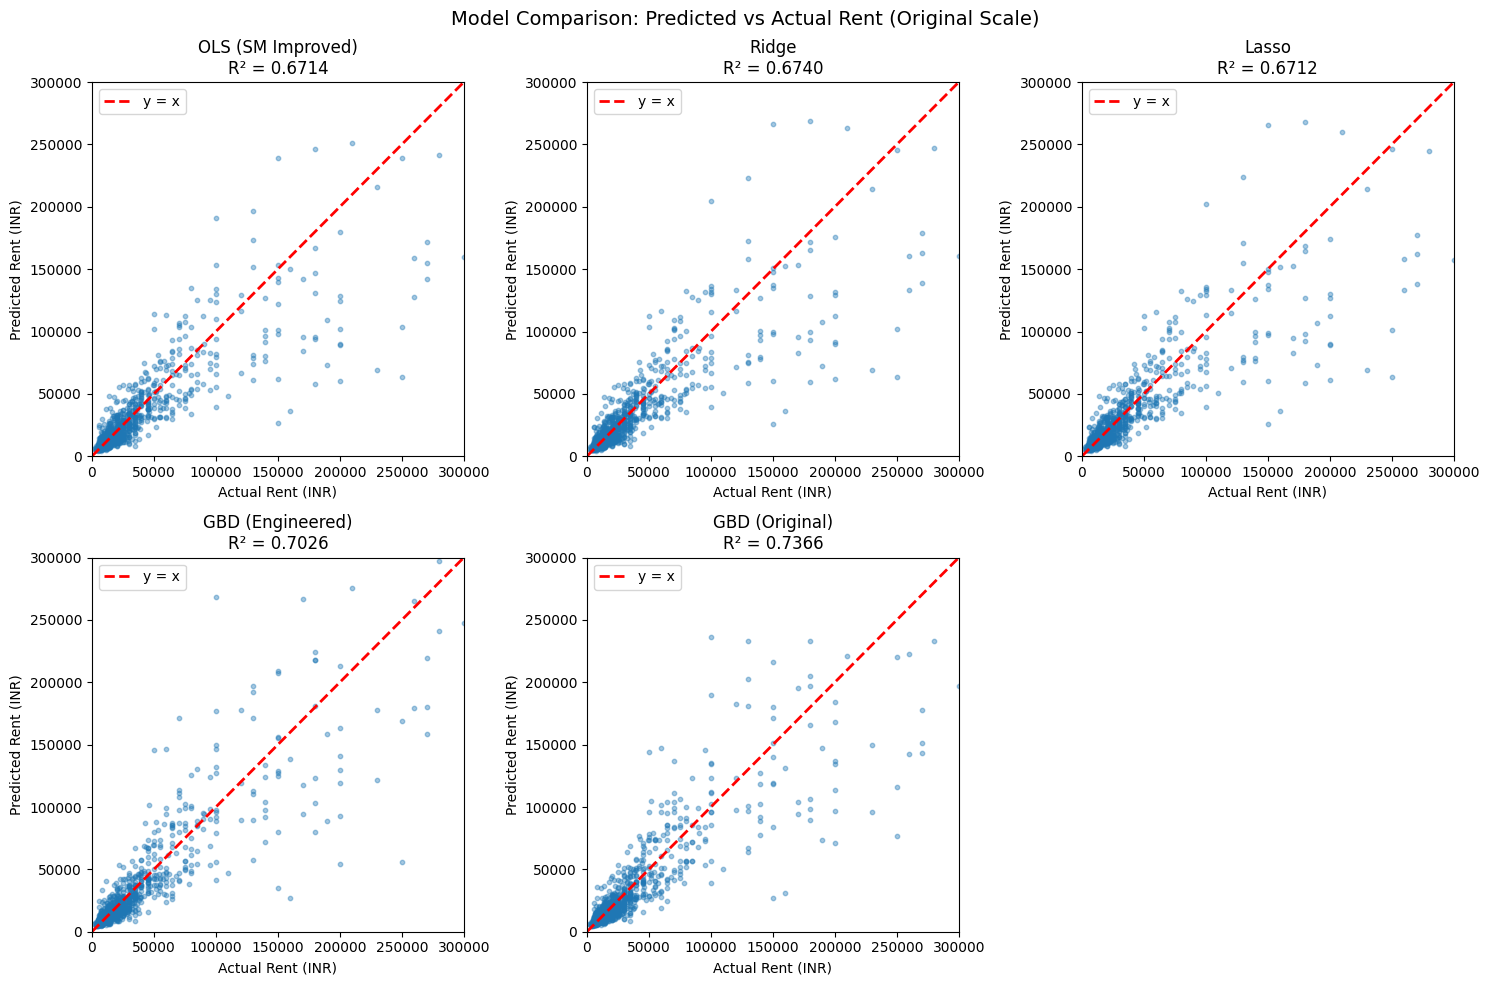

In [73]:
# Visualization: Predicted vs Actual for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plot_data = [
    ('OLS (SM Improved)', y_pred_improved_orig, r2_imp_orig),
    ('Ridge', np.expm1(y_pred_ridge), r2_score(y_test_orig_arr, np.expm1(y_pred_ridge))),
    ('Lasso', np.expm1(y_pred_lasso), r2_score(y_test_orig_arr, np.expm1(y_pred_lasso))),
    ('GBD (Engineered)', y_pred_gbd_eng_orig, r2_gbd_eng_orig),
    ('GBD (Original)', y_pred_gbd_orig_orig, r2_gbd_orig_orig),
]

max_val = 300000

for ax, (name, y_pred, r2) in zip(axes.flatten()[:5], plot_data):
    ax.scatter(y_test_orig_arr, y_pred, alpha=0.4, s=10)
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='y = x')
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('Actual Rent (INR)')
    ax.set_ylabel('Predicted Rent (INR)')
    ax.set_title(f'{name}\nR² = {r2:.4f}')
    ax.legend(loc='upper left')

# Hide the 6th subplot
axes[1, 2].axis('off')

plt.suptitle('Model Comparison: Predicted vs Actual Rent (Original Scale)', fontsize=14)
plt.tight_layout()
plt.show()

In [75]:
# Feature Importance from GBD models using Permutation Importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance for GBD on engineered features
print("Calculating permutation importance for GBD (engineered)...")
perm_imp_eng = permutation_importance(gbd_eng_best, X_test_final, y_test_arr, 
                                       n_repeats=10, random_state=42, n_jobs=-1)

importance_eng = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_imp_eng.importances_mean
}).sort_values('Importance', ascending=True).tail(15)

# Calculate permutation importance for GBD on original features
print("Calculating permutation importance for GBD (original)...")
perm_imp_orig = permutation_importance(gbd_orig_best, X_test_orig_all, y_test_log_orig,
                                        n_repeats=10, random_state=42, n_jobs=-1)

importance_orig = pd.DataFrame({
    'Feature': orig_feature_names,
    'Importance': perm_imp_orig.importances_mean
}).sort_values('Importance', ascending=True).tail(15)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(importance_eng['Feature'], importance_eng['Importance'])
axes[0].set_xlabel('Permutation Importance (decrease in R²)')
axes[0].set_title('GBD (Engineered Features) Top 15 Features')

axes[1].barh(importance_orig['Feature'], importance_orig['Importance'])
axes[1].set_xlabel('Permutation Importance (decrease in R²)')
axes[1].set_title('GBD (Original Features) Top 15 Features')

plt.tight_layout()
plt.show()

Calculating permutation importance for GBD (engineered)...
Calculating permutation importance for GBD (original)...


NameError: name 'orig_feature_names' is not defined

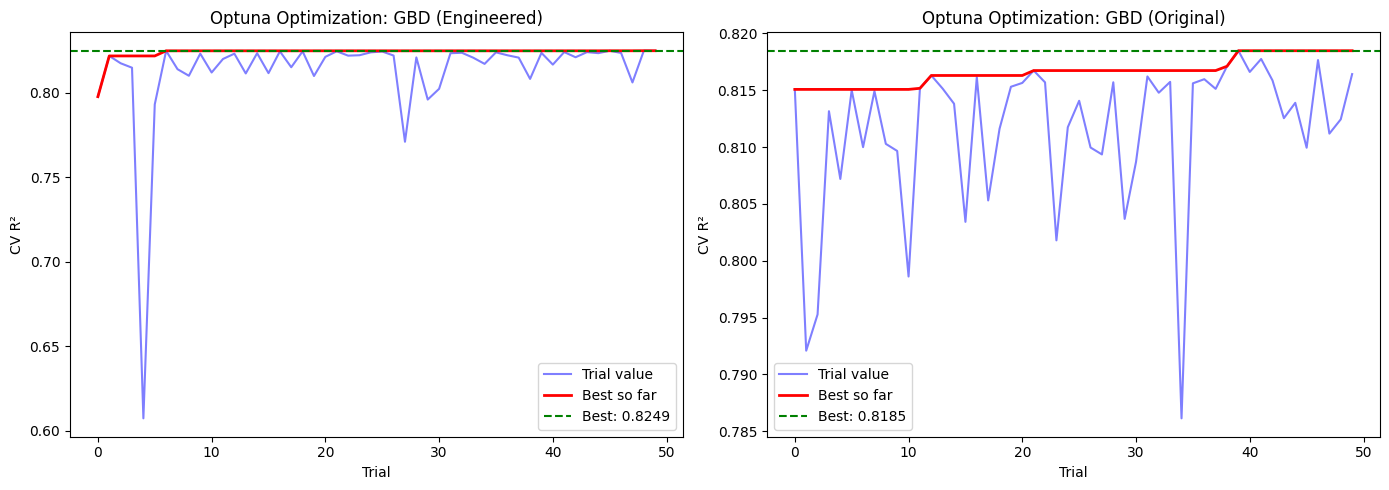

In [76]:
# Optuna optimization history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Engineered features study
trials_eng = study_eng.trials
values_eng = [t.value for t in trials_eng]
axes[0].plot(values_eng, 'b-', alpha=0.5, label='Trial value')
axes[0].plot(np.maximum.accumulate(values_eng), 'r-', linewidth=2, label='Best so far')
axes[0].axhline(study_eng.best_value, color='green', linestyle='--', label=f'Best: {study_eng.best_value:.4f}')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('CV R²')
axes[0].set_title('Optuna Optimization: GBD (Engineered)')
axes[0].legend()

# Original features study
trials_orig = study_orig.trials
values_orig = [t.value for t in trials_orig]
axes[1].plot(values_orig, 'b-', alpha=0.5, label='Trial value')
axes[1].plot(np.maximum.accumulate(values_orig), 'r-', linewidth=2, label='Best so far')
axes[1].axhline(study_orig.best_value, color='green', linestyle='--', label=f'Best: {study_orig.best_value:.4f}')
axes[1].set_xlabel('Trial')
axes[1].set_ylabel('CV R²')
axes[1].set_title('Optuna Optimization: GBD (Original)')
axes[1].legend()

plt.tight_layout()
plt.show()